In [1]:
import io
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2
import json

In [2]:
# input image
LABELS_file = 'imagenet-simple-labels.json'
image_file = 'test.jpg'

# networks such as googlenet, resnet, densenet already use global average pooling at the end, so CAM could be used directly.
model_id = 1
if model_id == 1:
    net = models.squeezenet1_1(pretrained=True)
    finalconv_name = 'features' # this is the last conv layer of the network
elif model_id == 2:
    net = models.resnet18(pretrained=True)
    finalconv_name = 'layer4'
elif model_id == 3:
    net = models.densenet161(pretrained=True)
    finalconv_name = 'features'
    
net.eval()

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [3]:
# hook the feature extrator
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
    
net._modules.get(finalconv_name).register_forward_hook(hook_feature)

# get the sofrmax weight
params = list(net.parameters()) # model.parameters() get the weights and bias for all layers
weight_softmax = np.squeeze(params[-2].data.numpy()) # remove dimensions whose value is one, get the weight of the last layer

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256*256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        # normalization
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        # recover
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [4]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
]) 

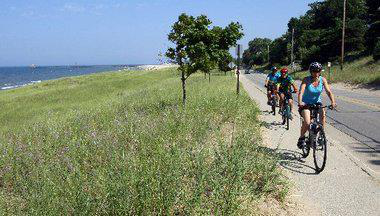

In [5]:
# load test image
img_pil = Image.open(image_file)
img_pil.show() # display image
img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0)) # pack tensor, load gradient information
logit = net(img_variable)

# load the imagenet category list
with open(LABELS_file) as f:
    classes = json.load(f)

In [6]:
h_x = F.softmax(logit, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

# output the prediction
for i in range(0, 5): # print top 5 predictions
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

# generate class activation mapping for the top 1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

# render the CAM and output
print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
img = cv2.imread('test.jpg')
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('result.jpg', result)

0.687 -> mountain bike
0.096 -> tandem bicycle
0.050 -> unicycle
0.033 -> horse-drawn vehicle
0.018 -> lakeshore
output CAM.jpg for the top1 prediction: mountain bike


True

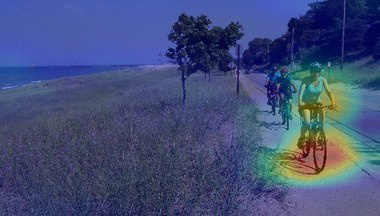

In [7]:
img = Image.open('./result.jpg')
img.show() # display image

In [25]:
params[-2].cpu().detach().numpy().shape

(1000, 512, 1, 1)

In [30]:
params[-2].data.numpy()[idx[0]].shape

(512, 1, 1)

In [27]:
features_blobs[0].shape

(1, 512, 13, 13)

In [34]:
feature_conv1 = features_blobs[0]
bz, nc, h, w = feature_conv1.shape

In [35]:
features_blobs[0].reshape((nc, h*w)).shape

(512, 169)

In [38]:
weight = np.squeeze(params[-2].data.numpy())
weight.shape

(1000, 512)

In [39]:
weight[idx[0]].shape

(512,)

In [40]:
weight_softmax[idx[0]].shape

(512,)

In [37]:
weight_softmax[idx[0]].dot(feature_conv1.reshape((nc, h*w))).shape

(169,)

In [28]:
idx[0]

671